In [1]:
pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [5]:
import os
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Original BERT-base

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/usr/local/lib/p

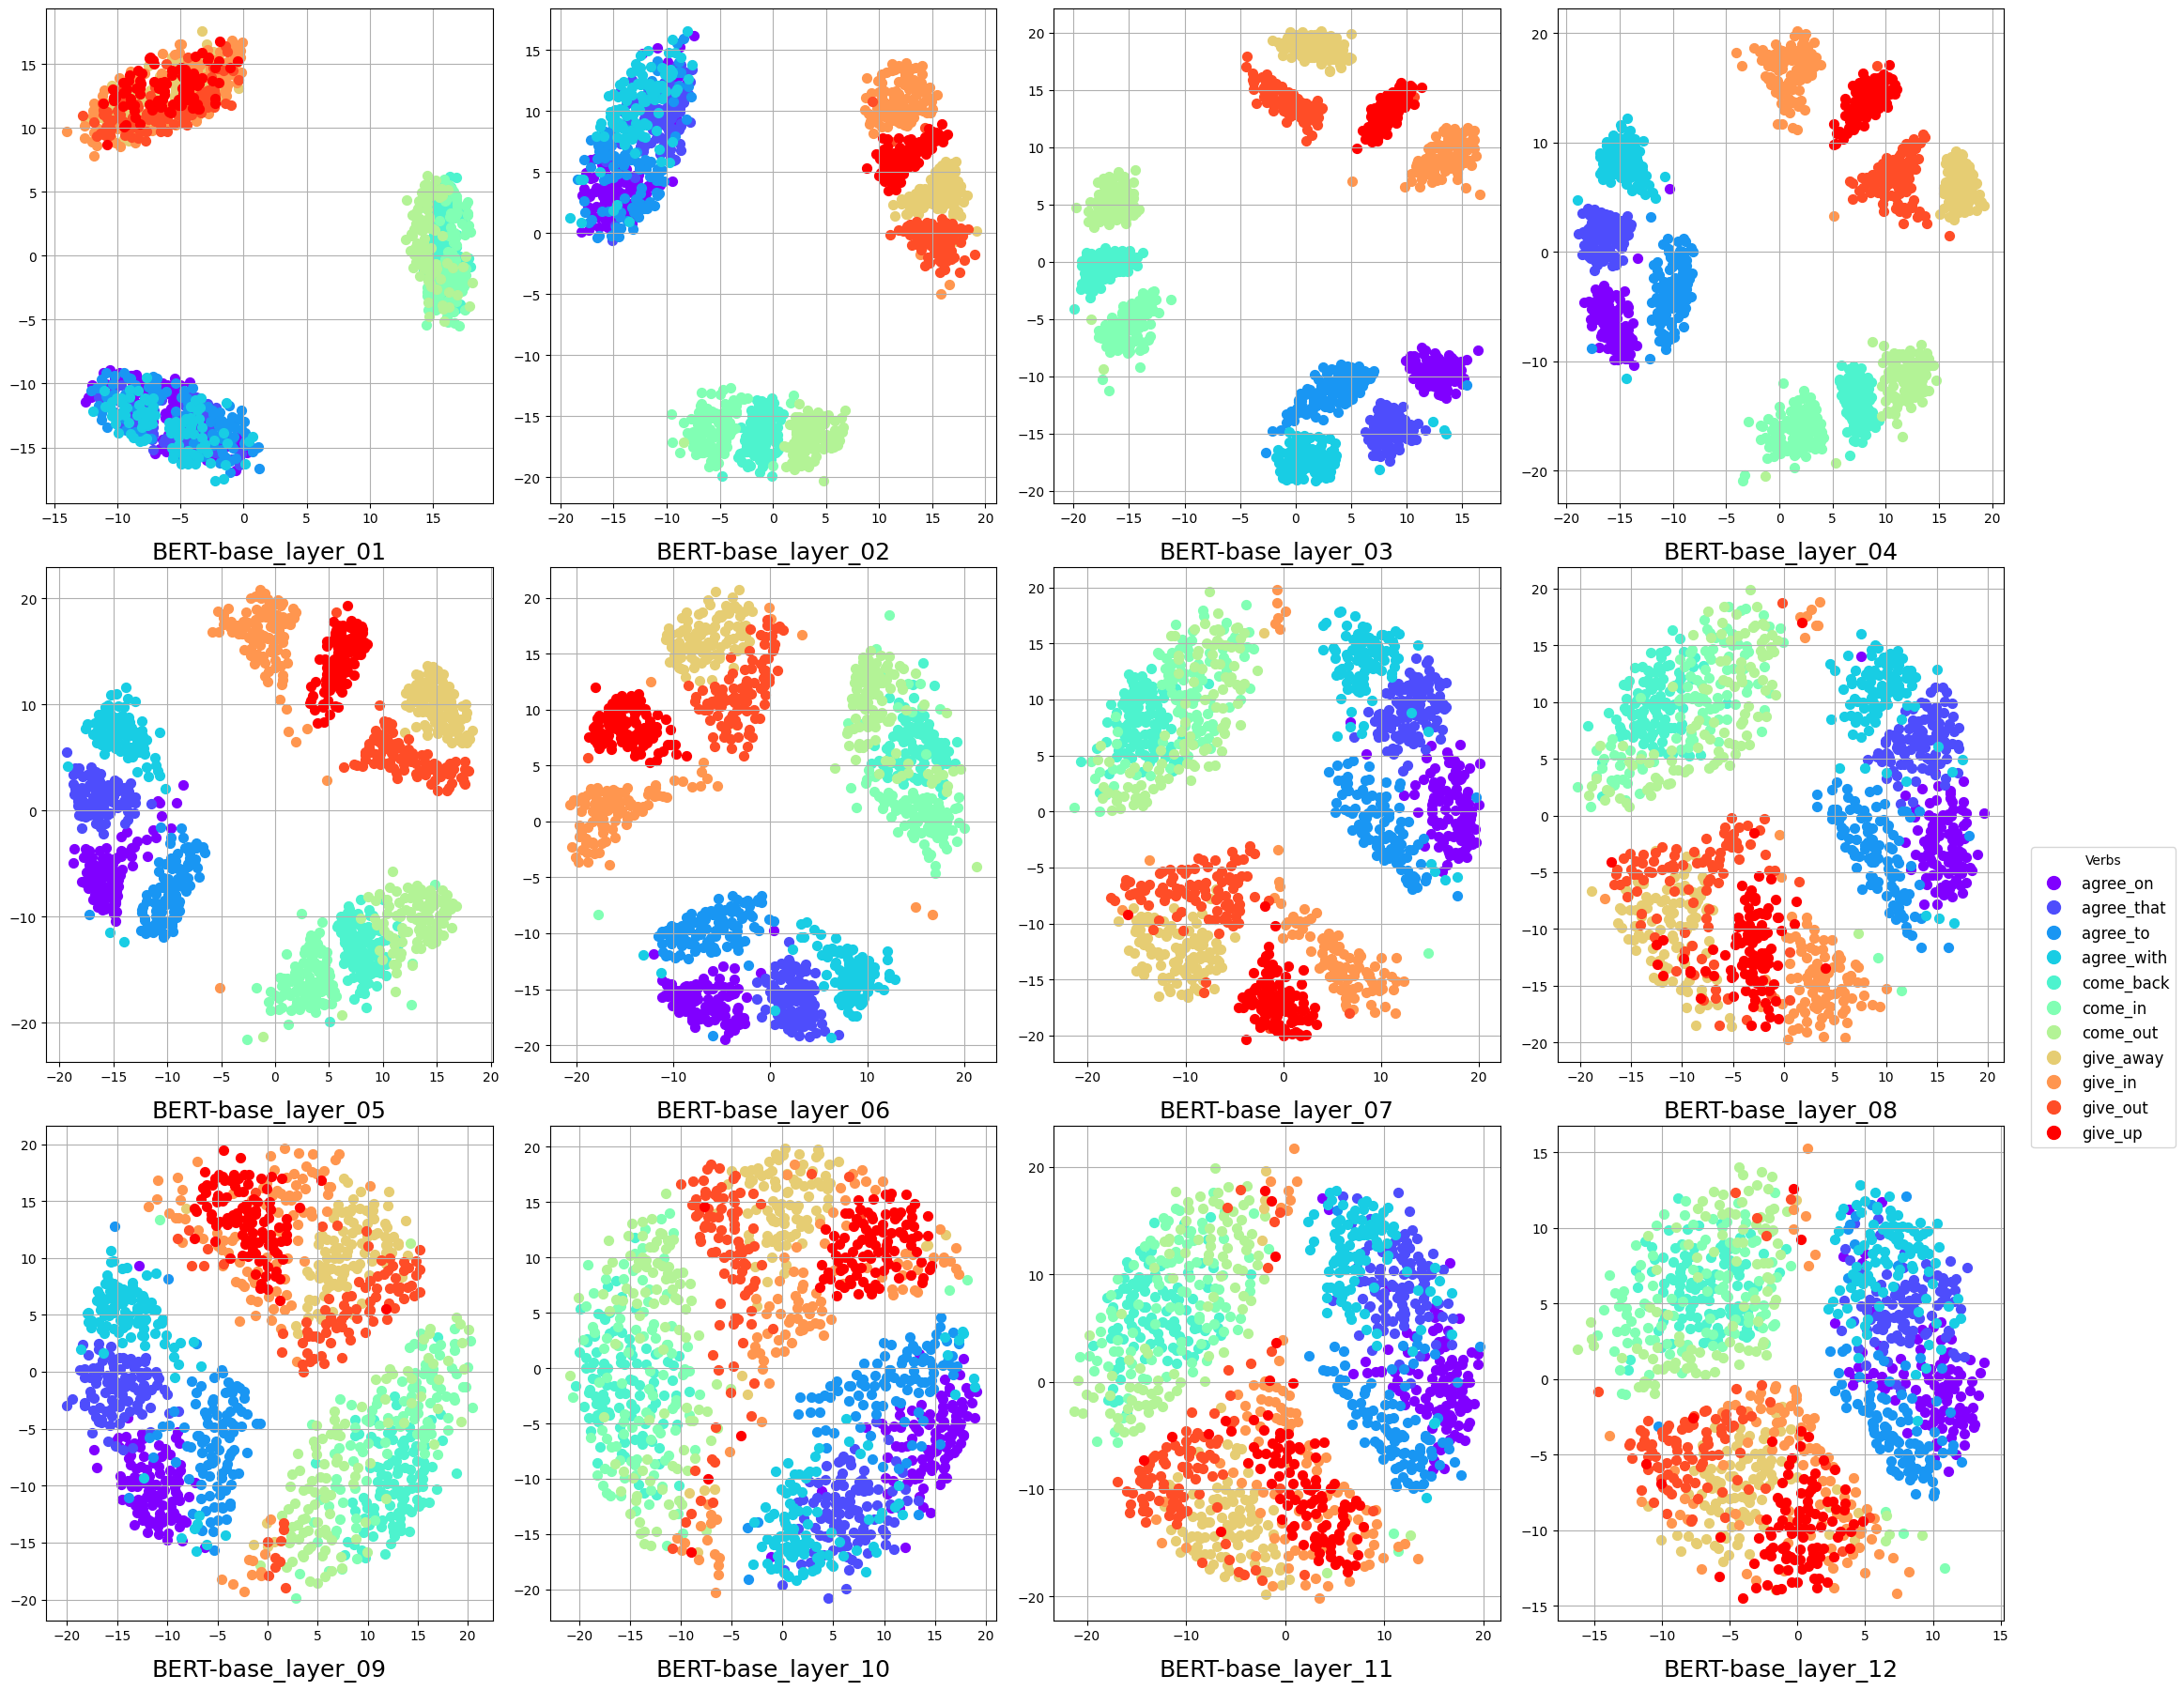

In [8]:
# List of .npz file paths (your example repeats the same file 12x)
file_paths = [
    '/content/BERT-base_layer_01.npz',
    '/content/BERT-base_layer_02.npz',
    '/content/BERT-base_layer_03.npz',
    '/content/BERT-base_layer_04.npz',
    '/content/BERT-base_layer_05.npz',
    '/content/BERT-base_layer_06.npz',
    '/content/BERT-base_layer_07.npz',
    '/content/BERT-base_layer_08.npz',
    '/content/BERT-base_layer_09.npz',
    '/content/BERT-base_layer_10.npz',
    '/content/BERT-base_layer_11.npz',
    '/content/BERT-base_layer_12.npz'
]

num_files = len(file_paths)
num_rows = 3
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 18))
axes = axes.flatten()

# Dictionary to accumulate color mapping for the legend
color_map = {}

for idx, file_path in enumerate(file_paths):
    data = np.load(file_path, allow_pickle=False)

    embeddings = []
    file_names = []
    # use data.files for explicit key list (order is fine)
    for key in data.files:
        embeddings.append(data[key])
        file_names.append(key)
    embeddings = np.vstack(embeddings)

    # Use MDS to reduce dimensionality
    mds = MDS(n_components=2, random_state=42)
    embeddings_2d = mds.fit_transform(embeddings)

    # Assign colors based on file names (keep color stable once set)
    n_verbs = len(file_names)
    colors = cm.rainbow(np.linspace(0, 1, n_verbs))
    for i in range(n_verbs):
        if file_names[i] not in color_map:  # <-- don't overwrite existing colors
            color_map[file_names[i]] = colors[i]

    # Plot each file's embeddings with a unique color
    start_idx = 0
    for i, file_name in enumerate(file_names):
        num_points = data[file_name].shape[0]
        end_idx = start_idx + num_points
        axes[idx].scatter(
            embeddings_2d[start_idx:end_idx, 0],
            embeddings_2d[start_idx:end_idx, 1],
            s=50,
            color=color_map[file_name],
            label=file_name,
            marker='o'
        )
        start_idx = end_idx

    # Title (strip .npz instead of .zip)
    file_title = os.path.basename(file_path).replace('.npz', '')  # <-- changed
    axes[idx].grid(True)
    axes[idx].annotate(file_title, xy=(0.5, -0.1), xycoords='axes fraction',
                       ha='center', va='center', fontsize=18)

# Hide any unused subplots (if file_paths length < number of subplots)
for j in range(len(file_paths), len(axes)):
    fig.delaxes(axes[j])

# Create a single legend for the entire figure
handles = [plt.Line2D([0], [0], marker='o', color=c, linestyle='', markersize=10)
           for _, c in color_map.items()]
labels = list(color_map.keys())

fig.legend(handles, labels, title='Verbs', loc='upper left',
           bbox_to_anchor=(0.9, 0.5), fontsize='large')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


gh

In [9]:
# === MDS stress + PCA variance per layer (Colab-safe) ===
import os, numpy as np, pandas as pd
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from IPython.display import display

# If you already defined `file_paths`, this will use it; otherwise define here:
try:
    file_paths
except NameError:
    file_paths = [
        '/content/BERT-base_layer_01.npz',
        '/content/BERT-base_layer_02.npz',
        '/content/BERT-base_layer_03.npz',
        '/content/BERT-base_layer_04.npz',
        '/content/BERT-base_layer_05.npz',
        '/content/BERT-base_layer_06.npz',
        '/content/BERT-base_layer_07.npz',
        '/content/BERT-base_layer_08.npz',
        '/content/BERT-base_layer_09.npz',
        '/content/BERT-base_layer_10.npz',
        '/content/BERT-base_layer_11.npz',
        '/content/BERT-base_layer_12.npz'
    ]

def load_npz_stack(path):
    d = np.load(path, allow_pickle=False)
    X = np.vstack([d[k] for k in d.files])  # (N, 768)
    return X, list(d.files)

def kruskal_stress1(X_high, X_low):
    """stress-1 = sqrt( sum((d - d')^2) / sum(d^2) ) with Euclidean distances."""
    Dh = pairwise_distances(X_high, metric="euclidean")
    Dl = pairwise_distances(X_low,  metric="euclidean")
    return np.sqrt(np.sum((Dh - Dl)**2) / (np.sum(Dh**2) + 1e-12))

# Explicit MDS config for reproducibility
mds_kwargs = dict(
    n_components=2, metric=True, n_init=10, max_iter=300, eps=1e-3,
    dissimilarity="euclidean", random_state=42
)

stress_rows, pca_rows = [], []

for idx, fpath in enumerate(file_paths, start=1):  # 1-indexed layer labels
    if not os.path.exists(fpath):
        print(f"(!) Missing file, skipping: {fpath}")
        continue

    X, _ = load_npz_stack(fpath)

    # MDS (metric SMACOF) + stress-1
    mds = MDS(**mds_kwargs)
    X2  = mds.fit_transform(X)
    s1  = kruskal_stress1(X, X2)
    stress_rows.append({
        "layer": idx,
        "file": os.path.basename(fpath),
        "n_tokens": int(X.shape[0]),
        "mds_variant": "metric (SMACOF), euclidean",
        "random_state": 42,
        "stress1": float(s1)
    })

    # PCA 2D variance
    pca = PCA(n_components=2, random_state=42)
    Xp  = pca.fit_transform(X)
    evr = pca.explained_variance_ratio_
    pca_rows.append({
        "layer": idx,
        "file": os.path.basename(fpath),
        "n_tokens": int(X.shape[0]),
        "pc1_var": float(evr[0]),
        "pc2_var": float(evr[1]),
        "pc1_plus_pc2": float(evr.sum())
    })

df_stress = pd.DataFrame(stress_rows).sort_values("layer")
df_pca    = pd.DataFrame(pca_rows).sort_values("layer")

# Save & show
df_stress.to_csv("mds_stress_table.csv", index=False)
df_pca.to_csv("pca_2d_variance_table.csv", index=False)
display(df_stress)
display(df_pca)

# Ready-to-paste summary lines for Results
def summary_lines(df_stress, df_pca):
    if len(df_stress):
        med = df_stress['stress1'].median()
        q1  = df_stress['stress1'].quantile(0.25)
        q3  = df_stress['stress1'].quantile(0.75)
        print(f"Kruskal stress-1 (median [IQR]) across layers = {med:.3f} [{q1:.3f}–{q3:.3f}].")
    if len(df_pca):
        medv = df_pca['pc1_plus_pc2'].median()
        q1v  = df_pca['pc1_plus_pc2'].quantile(0.25)
        q3v  = df_pca['pc1_plus_pc2'].quantile(0.75)
        print(f"PCA 2D variance (median [IQR]) across layers = {medv:.3f} [{q1v:.3f}–{q3v:.3f}].")

summary_lines(df_stress, df_pca)

print("\nSaved files: mds_stress_table.csv, pca_2d_variance_table.csv")

,layer,file,n_tokens,mds_variant,random_state,stress1
0,1,BERT-base_layer_01.npz,1092,"metric (SMACOF), euclidean",42,0.171356
1,2,BERT-base_layer_02.npz,1092,"metric (SMACOF), euclidean",42,0.207312
2,3,BERT-base_layer_03.npz,1092,"metric (SMACOF), euclidean",42,0.231570
3,4,BERT-base_layer_04.npz,1092,"metric (SMACOF), euclidean",42,0.267346
4,5,BERT-base_layer_05.npz,1092,"metric (SMACOF), euclidean",42,0.287441
5,6,BERT-base_layer_06.npz,1092,"metric (SMACOF), euclidean",42,0.308403
6,7,BERT-base_layer_07.npz,1092,"metric (SMACOF), euclidean",42,0.334135
7,8,BERT-base_layer_08.npz,1092,"metric (SMACOF), euclidean",42,0.428316
8,9,BERT-base_layer_09.npz,1092,"metric (SMACOF), euclidean",42,0.422117
9,10,BERT-base_layer_10.npz,1092,"metric (SMACOF), euclidean",42,0.421035


,layer,file,n_tokens,pc1_var,pc2_var,pc1_plus_pc2
0,1,BERT-base_layer_01.npz,1092,0.464913,0.363056,0.827969
1,2,BERT-base_layer_02.npz,1092,0.421865,0.326957,0.748821
2,3,BERT-base_layer_03.npz,1092,0.375528,0.288305,0.663833
3,4,BERT-base_layer_04.npz,1092,0.323172,0.240934,0.564107
4,5,BERT-base_layer_05.npz,1092,0.284189,0.216513,0.500702
5,6,BERT-base_layer_06.npz,1092,0.257257,0.191224,0.448481
6,7,BERT-base_layer_07.npz,1092,0.222703,0.157637,0.380339
7,8,BERT-base_layer_08.npz,1092,0.195189,0.117374,0.312563
8,9,BERT-base_layer_09.npz,1092,0.162742,0.093899,0.256641
9,10,BERT-base_layer_10.npz,1092,0.144521,0.081113,0.225634


Kruskal stress-1 (median [IQR]) across layers = 0.321 [0.258–0.421].
PCA 2D variance (median [IQR]) across layers = 0.414 [0.255–0.589].

Saved files: mds_stress_table.csv, pca_2d_variance_table.csv


Handeling outliers

In [ ]:
import numpy as np, pandas as pd

def build_point_map(npz_path, excel_with_idx="Data_for_MDS_with_indices.xlsx"):
    # Load Excel with the per-verb running index we created
    df = pd.read_excel(excel_with_idx)
    # Sanity: counts per verb
    excel_counts = df.groupby("verb")["row_in_verb"].max().add(1).to_dict()

    # Load .npz (note allow_pickle=False) and use a context manager
    with np.load(npz_path, allow_pickle=False) as d:
        keys = list(d.files)                      # verb order as saved in .npz
        sizes = [d[k].shape[0] for k in keys]     # tokens per verb

        # Optional consistency check
        for k, n in zip(keys, sizes):
            if excel_counts.get(k, -1) != n:
                print(f"[WARN] {npz_path}: '{k}' has npz={n}, excel={excel_counts.get(k,0)}")

        # Build mapping DF: one row per point in the concatenated embedding matrix
        rows, start = [], 0
        for verb, n in zip(keys, sizes):
            for i in range(n):
                rows.append({"global_index": start+i, "verb": verb, "row_in_verb": i})
            start += n

    mapping = pd.DataFrame(rows)
    # Attach the text/metadata columns from Excel
    mapping = mapping.merge(df, on=["verb","row_in_verb"], how="left", validate="m:1")
    return mapping

# Example (use .npz path, not .zip):
point_map = build_point_map("/content/CxG_layer_01_2-10000.npz")
point_map.head()


,global_index,verb,row_in_verb,Number of hit,Text ID,Concordance line,Tagged concordance line,URL,Match-begin corpus position,Match-end corpus position,pos_tag
0,0,agree_on,0,1,HSF,. But to patch things up the friends need to a...,._PUN But_CJC to_TO0 patch_VVI things_NN2 up_P...,https://cqpweb.lancs.ac.uk/bncxmlweb/context.p...,86454795,86454798,agree_on_AT0
1,1,agree_on,1,2,J6Y,Law Society appointing the bank if the parties...,Law_NN1 Society_NN1 appointing_VVG the_AT0 ban...,https://cqpweb.lancs.ac.uk/bncxmlweb/context.p...,94441495,94441498,agree_on_AT0
2,2,agree_on,2,3,BPH,"fair or just , in 1842 they were able to agree...","fair_AJ0 or_CJC just_AV0 ,_PUN in_PRP 1842_CRD...",https://cqpweb.lancs.ac.uk/bncxmlweb/context.p...,23180118,23180121,agree_on_AT0
3,3,agree_on,3,4,EDP,by Korea ; the provisional government and the ...,by_PRP Korea_NP0 ;_PUN the_AT0 provisional_AJ0...,https://cqpweb.lancs.ac.uk/bncxmlweb/context.p...,46620349,46620352,agree_on_AT0
4,4,agree_on,4,5,J6Y,valuer acting as an expert if the parties can ...,valuer_NN1 acting_VVG as_PRP an_AT0 expert_NN1...,https://cqpweb.lancs.ac.uk/bncxmlweb/context.p...,94433167,94433170,agree_on_AT0


In [ ]:
import numpy as np, pandas as pd
from sklearn.manifold import MDS

EXCEL = "Data_for_MDS_with_indices.xlsx"         # <- indexed Excel
NPZ    = "/content/CxG_layer_12_2-10000.npz"     # <- use .npz here
Q      = 0.95                                     # outlier quantile (top 5%)

def build_point_map(npz_path, excel_with_idx=EXCEL):
    df = pd.read_excel(excel_with_idx)
    with np.load(npz_path, allow_pickle=False) as d:
        keys  = list(d.files)                       # verbs order in the .npz
        sizes = [d[k].shape[0] for k in keys]

        rows, start = [], 0
        for verb, n in zip(keys, sizes):
            for i in range(n):
                rows.append({"global_index": start+i, "verb": verb, "row_in_verb": i})
            start += n

    mapping = pd.DataFrame(rows).merge(df, on=["verb","row_in_verb"], how="left", validate="m:1")
    return mapping, keys, sizes

def compute_mds_Y(npz_path):
    # Euclidean MDS on raw embeddings per layer
    with np.load(npz_path, allow_pickle=False) as d:
        X = np.vstack([d[k] for k in d.files])
    mds = MDS(n_components=2, random_state=42)
    Y = mds.fit_transform(X)
    return Y

def mark_outliers(Y, sizes, q=Q):
    mask = np.zeros(len(Y), dtype=bool)
    start = 0
    for n in sizes:
        seg  = Y[start:start+n]
        mu   = seg.mean(axis=0)
        dist = np.linalg.norm(seg - mu, axis=1)
        thr  = np.quantile(dist, q)
        mask[start:start+n] = dist > thr
        start += n
    return mask

# --- run for one layer ---
point_map, verbs, sizes = build_point_map(NPZ, EXCEL)
Y = compute_mds_Y(NPZ)
outlier_mask = mark_outliers(Y, sizes, q=Q)
outlier_idx = np.where(outlier_mask)[0]

# Map to labels + text
outliers_with_text = point_map.loc[point_map["global_index"].isin(outlier_idx)].copy()
print(outliers_with_text[["verb","row_in_verb","Text ID","Concordance line"]].head(15))

# Save
outliers_with_text.to_csv(NPZ.replace(".npz","_outliers_with_text.csv"), index=False)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


           verb  row_in_verb Text ID  \
14     agree_on           14     B2U   
21     agree_on           21     J1A   
25     agree_on           25     A7N   
33     agree_on           33     AP0   
44     agree_on           44     CDC   
103  agree_with            3     JJP   
130  agree_with           30     C88   
160  agree_with           60     CCU   
178  agree_with           78     FL4   
186  agree_with           86     HHV   
202  agree_that            2     G17   
250  agree_that           50     HJ5   
262  agree_that           62     HHW   
279  agree_that           79     CBT   
295  agree_that           95     HHV   

                                      Concordance line  
14   will be the sales assistant and which the cust...  
21   Vol des Zephirs &rsquo; ( Act 5 scene 7 ) agre...  
25   is very willing to listen , to advise , to agr...  
33   pulled a switchblade on his director because t...  
44   3 ) hold a free election ; ( 4 ) agree on the ...  
103  anyone else 

In [ ]:
import pandas as pd
import glob
import re

# Match all your files in Colab
files = glob.glob("/content/layer_*_outliers_with_text.csv")

dfs = []
for file in sorted(files):
    df = pd.read_csv(file)

    # Extract layer number from filename
    match = re.search(r"layer_(\d+)_", file)
    if match:
        layer_num = int(match.group(1))
        df["layer"] = layer_num

    dfs.append(df)

# Combine all layers
combined_df = pd.concat(dfs, ignore_index=True)

# Save to one CSV
combined_df.to_csv("BERT-base_all_layers_combined.csv", index=False)

print("Saved as BERT-base_all_layers_combined.csv with shape:", combined_df.shape)


Saved as BERT-base_all_layers_combined.csv with shape: (660, 12)
